In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("code")

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io.wavfile as wave
from tqdm import tqdm_notebook
import IPython
import sklearn.decomposition as skd

import utils
import em

# Reading data

In [2]:
#Data
prefix = "voice"
assert prefix in ["voice", "nodrums", "wdrums"]

files = {"mix": "data/{}_mix.wav".format(prefix),
         "sources": ["data/{}_src1.wav".format(prefix),
                     "data/{}_src2.wav".format(prefix),
                     "data/{}_src3.wav".format(prefix)]}

n_secs = 3.0

rate, _, mix = utils.readwav(files["mix"])
mix = mix[:int(n_secs * rate)]
maxi = np.max(mix)
mix = mix / maxi

T, I = mix.shape
print("rate = {}".format(rate))
print("T    = {}".format(T))
print("I    = {}".format(I))
IPython.display.Audio(mix.transpose(), rate = rate)

rate = 16000
T    = 48000
I    = 2


# Parameters

In [3]:
#STFT
stft_win_len = int(64 * 10**(-3) * rate)
freq_max = 2000
resolution = 1
noverlap = None

#Inputs
coef_add_noise = 1e-3
coef_mult_noise = 1e-3
coef_mix = .1

#NMF init
nmf_noise = 1e-2
Kpart = [4, 4, 4]
K = np.sum(Kpart)

#EM
n_iter = 25
normalize = True

In [4]:
perturbated_sources, true_sources = utils.create_inputs(files["sources"], maxi = maxi,
                                                        coef_add_noise = coef_add_noise,
                                                        coef_mult_noise = coef_mult_noise,
                                                        coef_mix = coef_mix)
perturbated_sources = perturbated_sources[:, :int(n_secs * rate)]
true_sources = true_sources[:, :int(n_secs * rate)]
J = perturbated_sources.shape[0]
print("J = {}".format(J))

J = 3


F = 128
N = 95


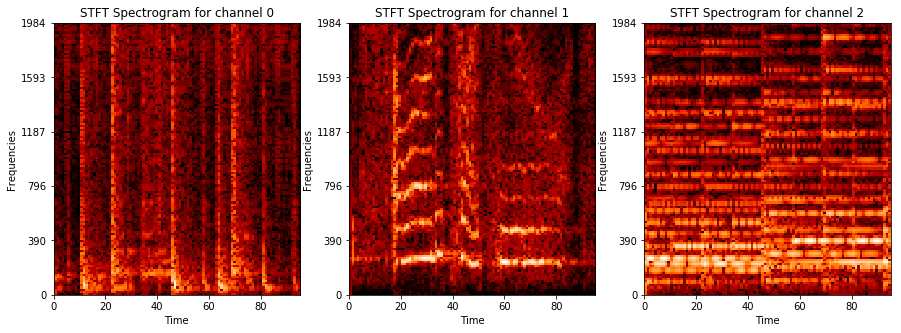

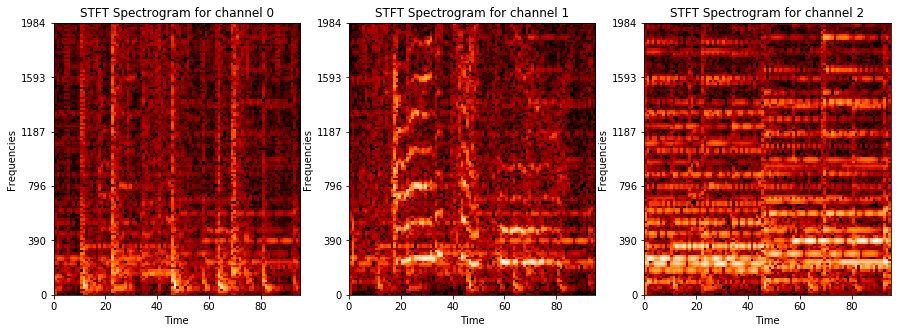

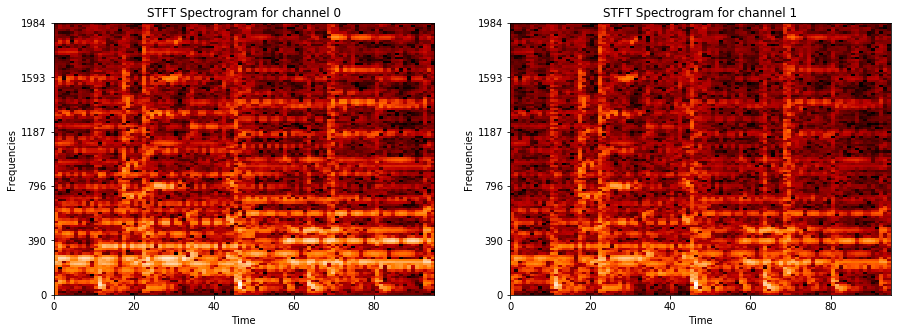

In [5]:
freqs, _, S = sig.stft(perturbated_sources, fs = rate, noverlap = noverlap,
                       nperseg = resolution * stft_win_len, return_onesided = True)
_, _, true_S = sig.stft(true_sources, fs = rate, noverlap = noverlap,
                        nperseg = resolution * stft_win_len, return_onesided = True)
_, _, X = sig.stft(mix.transpose(), fs = rate, noverlap = noverlap,
                   nperseg = resolution * stft_win_len, return_onesided = True)

mini = np.argmin(np.abs(freqs - freq_max))
final_freqs = freqs[:mini]
S = S[:, :mini]
true_S = true_S[:, :mini]
X = X[:, :mini]

F = len(final_freqs)
N = S[0].shape[-1]
print("F = {}".format(F))
print("N = {}".format(N))

utils.plot_stft(final_freqs, true_S)
utils.plot_stft(final_freqs, S)
utils.plot_stft(final_freqs, X)

true_S = true_S.transpose(1, 2, 0)
S = S.transpose(1, 2, 0)
X = X.transpose(1, 2, 0)

output = utils.resynthesize_src(S, maxi, final_freqs, freqs, noverlap)
IPython.display.Audio(output[1].transpose() * maxi, rate = rate)

# Algorithm
## Parameters initialization

In [6]:
print("K     = {}".format(K))
print("Kpart = {}".format(Kpart))

A, W, H, sigma_b, Rxx, Rxs, Rss = em.init_params(X, S, Kpart, nmf_noise = nmf_noise)
if normalize:A, W, H = em.normalize(A, W, H, Kpart)

K     = 12
Kpart = [4, 4, 4]


## Iterations

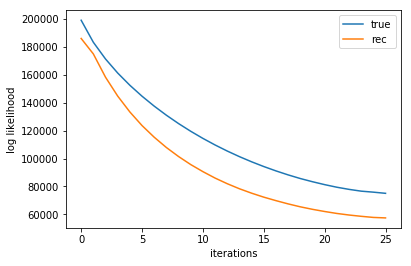

In [7]:
loglikes_true = [utils.compute_loglike(true_S, W, H, Kpart)]
loglikes_rec = [utils.compute_loglike(S, W, H, Kpart)]

for i in tqdm_notebook(range(1, n_iter + 1)):
    Rxx, Rxs, Rss, U, S = em.compute_E_step(X, A, W, H, sigma_b, Kpart)
    
    #loglikes_true += [utils.compute_loglike(true_S, W, H, Kpart)]
    #loglikes_rec += [utils.compute_loglike(S, W, H, Kpart)]
    
    A, _, W, H = em.compute_M_step(Rxx, Rxs, Rss, U, W, H)
    
    #loglikes_true += [utils.compute_loglike(true_S, W, H, Kpart)]
    #loglikes_rec += [utils.compute_loglike(S, W, H, Kpart)]
    if normalize:A, W, H = em.normalize(A, W, H, Kpart)
    
    loglikes_true += [utils.compute_loglike(true_S, W, H, Kpart)]
    loglikes_rec += [utils.compute_loglike(S, W, H, Kpart)]
    
    if(loglikes_rec[-1] > loglikes_rec[-2]):
        break
    
utils.plot_loglike([loglikes_true, loglikes_rec])

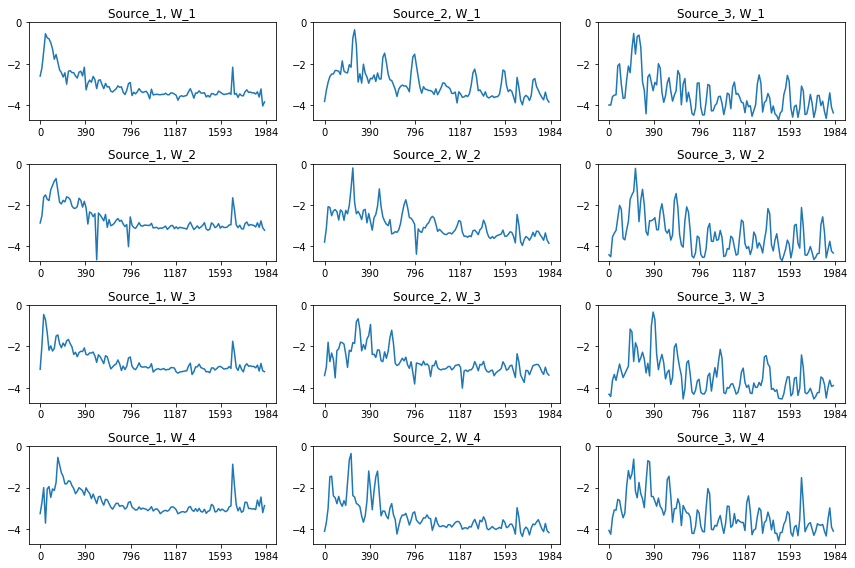

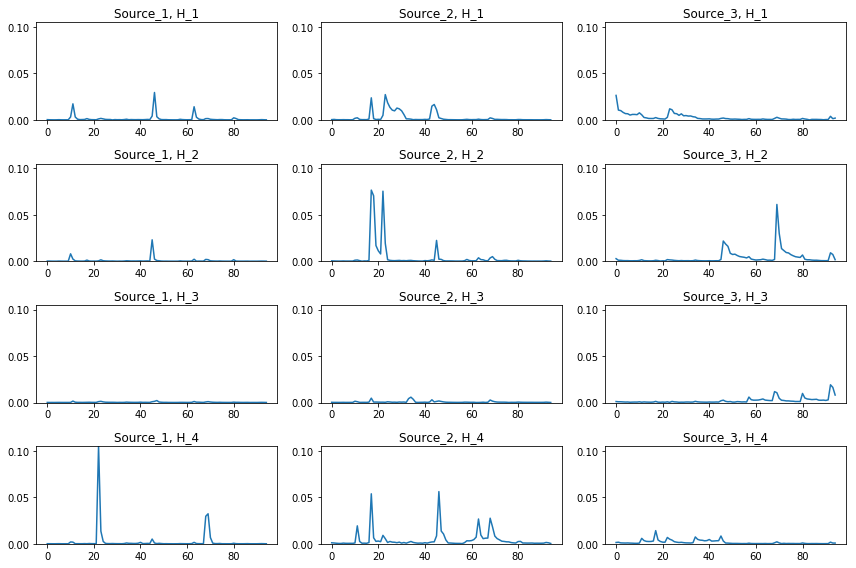

In [8]:
utils.plot_W_H(W, H, final_freqs, Kpart)

## Reconstruction

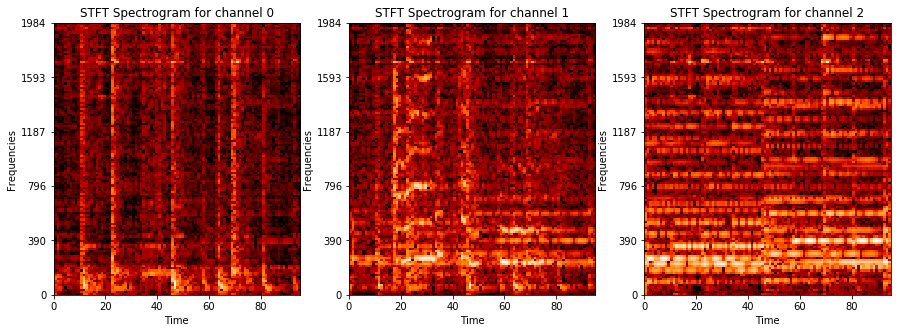

In [9]:
utils.plot_stft(final_freqs, S.transpose(2, 0, 1))
output = utils.resynthesize_src(S, maxi, final_freqs, freqs, noverlap = noverlap)
IPython.display.Audio(output[0].transpose() * maxi, rate = rate)

In [10]:
IPython.display.Audio(output[1].transpose() * maxi, rate = rate)

In [11]:
IPython.display.Audio(output[2].transpose() * maxi, rate = rate)

$$A_\text{inst} = \mathfrak{R}\left\{\sum_f \hat{R}_{xs, f}\right\}\left[\mathfrak{R}\left\{\sum_f \hat{R}_{ss, f}\right\}\right]^{-1}$$